In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import re
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import clear_output


In [2]:
def extract_answer(text):
    try:
        text_processed = text.split('"answer":')[-1].split('\n')[0].strip().split('"')[1].strip()
    except:
        text_processed = text.split('"answer":')[-1].split('\n')[0].strip()
    return text_processed

def correct_paranthesis_split(text):
    try:
        text_processed = text.split('"answer":')[-1].split("\n")[1].split(":")[-1].split('"')[1].strip()
        return text_processed
    except:
        return text
    
def process_df(rag_response_df):
    rag_response_df.loc[:, 'extracted_answer'] = rag_response_df['llm_answer'].apply(extract_answer)


    rag_response_df_paranthesis_split = rag_response_df[rag_response_df.extracted_answer=="{"]
    if rag_response_df_paranthesis_split.shape[0] > 0:
        rag_response_df_paranthesis_split.loc[:, "extracted_answer"] = rag_response_df_paranthesis_split.llm_answer.apply(correct_paranthesis_split)
        rag_response_df_wo_paranthesis_split = rag_response_df[rag_response_df.extracted_answer != "{"]
        rag_response_df = pd.concat([rag_response_df_wo_paranthesis_split, rag_response_df_paranthesis_split])
    return rag_response_df

def evaluate(df):
    correct = df[df.correct_answer == df.extracted_answer]
    incorrect = df[df.correct_answer != df.extracted_answer]
    correct_frac = correct.shape[0]/df.shape[0]
    incorrect_frac = incorrect.shape[0]/df.shape[0]
    return correct_frac, incorrect_frac

def evaluate_2(df):
    correct = df[df.cypher_rag_eval == True]
    incorrect = df[df.cypher_rag_eval == False]
    correct_frac = correct.shape[0]/df.shape[0]
    incorrect_frac = incorrect.shape[0]/df.shape[0]
    return correct_frac, incorrect_frac


def bootstrap(cypher_rag, kg_rag, niter=1000, nsample=150):
    cypher_rag_correct_frac_list = []
    kg_rag_correct_frac_list = []
    for i in tqdm(range(niter)):
        cypher_rag_response_df_sample = cypher_rag.sample(n=nsample, random_state=i)
        cypher_rag_correct_frac, cypher_rag_incorrect_frac = evaluate_2(cypher_rag_response_df_sample)
        kg_rag_response_df_sample = kg_rag.iloc[cypher_rag_response_df_sample.index]
        kg_rag_correct_frac, kg_rag_incorrect_frac = evaluate(kg_rag_response_df_sample)
        cypher_rag_correct_frac_list.append(cypher_rag_correct_frac)
        kg_rag_correct_frac_list.append(kg_rag_correct_frac)
    return cypher_rag_correct_frac_list, kg_rag_correct_frac_list

def plot_figure(cypher_rag_correct_frac_list, kg_rag_correct_frac_list):
    fig = plt.figure(figsize=(5, 3))
    ax = plt.gca()
    sns.kdeplot(cypher_rag_correct_frac_list, color="blue", shade=True, label="Cypher-RAG", ax=ax, lw=2, linestyle="-", alpha=0.6)
    sns.kdeplot(kg_rag_correct_frac_list, color="lightcoral", shade=True, label="KG-RAG", ax=ax, lw=2, linestyle="-", alpha=0.6)

    for artist in ax.lines:
        artist.set_edgecolor("black")
    plt.xlabel("Accuracy")
    plt.ylabel("Density")
    plt.legend(bbox_to_anchor=(0.45, 0.9))
    plt.xlim(0.1,0.9)
    ax.axvline(np.mean(cypher_rag_correct_frac_list), color='black', linestyle='--', lw=2)
    ax.axvline(np.mean(kg_rag_correct_frac_list), color='black', linestyle='--', lw=2)
    sns.despine(top=True, right=True)
    plt.show()
    return fig


In [3]:
cypher_rag = pd.read_csv('../data/results/cypher_rag_mcq_output_with_eval.csv')
kg_rag = pd.read_csv('../data/results/gpt_4_PubMedBert_entity_recognition_based_node_retrieval_rag_based_mcq_from_monarch_and_robokop_response.csv')


In [4]:
kg_rag = process_df(kg_rag)


In [5]:
cypher_rag_correct_frac_list, kg_rag_correct_frac_list = bootstrap(cypher_rag, kg_rag)


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1203.58it/s]


/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_63840/889265924.py:56: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cypher_rag_correct_frac_list, color="blue", shade=True, label="Cypher-RAG", ax=ax, lw=2, linestyle="-", alpha=0.6)
/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_63840/889265924.py:57: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(kg_rag_correct_frac_list, color="lightcoral", shade=True, label="KG-RAG", ax=ax, lw=2, linestyle="-", alpha=0.6)


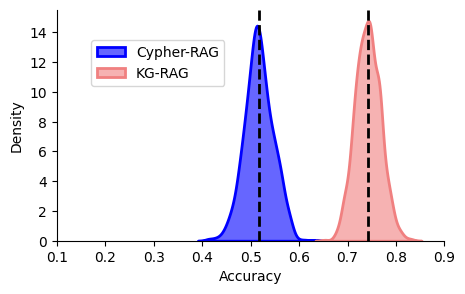

---Cypher-RAG based mean and std---
0.51674
0.02966020828577499

---KG-RAG based mean and std---
0.7417666666666666
0.0259921141887304


In [9]:
cypher_rag_vs_kg_rag_fig = plot_figure(cypher_rag_correct_frac_list, kg_rag_correct_frac_list)

fig_path = '../data/results/figures'
os.makedirs(fig_path, exist_ok=True)
cypher_rag_vs_kg_rag_fig.savefig(os.path.join(fig_path, 'cypher_rag_vs_kg_rag_mcq.svg'), format='svg', bbox_inches='tight')      

print('---Cypher-RAG based mean and std---')
print(np.mean(cypher_rag_correct_frac_list))
print(np.std(cypher_rag_correct_frac_list))
print('')
print('---KG-RAG based mean and std---')
print(np.mean(kg_rag_correct_frac_list))
print(np.std(kg_rag_correct_frac_list))
